In [36]:
# this loads and prepares the model for inference (use inference function)

from pathlib import Path
import timm
import torch
import torch.nn as nn
import torchvision.transforms as T
import cv2

# --------------------
# CONFIG
# --------------------


IMG_SIZE = 224

NUM_CLASSES = 7
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

notebook_path: Path = Path().resolve()
root_dir: Path = notebook_path.parent
WEIGHTS_PATH = root_dir/"models"/"step2_swin.pth"
WEIGHTS_UNTRAINED_PATH = root_dir/"models"/"swin_tiny_untrained_init.pth"

base_model = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=0
)

head = nn.Sequential(
    nn.Linear(base_model.num_features, 128),
    nn.ReLU(),
    nn.Linear(128, NUM_CLASSES),
)

class SwinWithHead(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        features = self.backbone(x)
        out = self.head(features)
        return out

model = SwinWithHead(base_model, head)
un_model = SwinWithHead(base_model, head)

state = torch.load(WEIGHTS_PATH, map_location='cpu')
model.load_state_dict(state)

state_untrained = torch.load(WEIGHTS_UNTRAINED_PATH, map_location='cpu')
un_model.load_state_dict(state_untrained)

model.eval()
un_model.eval()

# preprocessing
transform = T.Compose([
    T.ToTensor(),
    T.Resize((IMG_SIZE, IMG_SIZE))
])

def inference(face_crop, img_path: str | None = None):
    if img_path is not None:
      # read image from disk (BGR)
      face_crop = cv2.imread(img_path)
      if face_crop is None:
          raise ValueError(f"Could not read image from path: {img_path}")

    # BGR → RGB
    img = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

    # preprocess
    x = transform(img).unsqueeze(0)   # shape: (1,3,224,224)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_proba = probs[0, pred_idx].item()

    pred_class = CLASS_NAMES[pred_idx]
    return pred_class, pred_proba

def inference_untrained(face_crop, img_path: str | None = None):
    if img_path is not None:
      # read image from disk (BGR)
      face_crop = cv2.imread(img_path)
      if face_crop is None:
          raise ValueError(f"Could not read image from path: {img_path}")

    # BGR → RGB
    img = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

    # preprocess
    x = transform(img).unsqueeze(0)   # shape: (1,3,224,224)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_proba = probs[0, pred_idx].item()

    pred_class = CLASS_NAMES[pred_idx]
    return pred_class, pred_proba

In [ ]:
# live cam emotion detection

import cv2
import mediapipe as mp
from IPython.display import display, clear_output
from PIL import Image


mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)

with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5) as face_detection:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # MediaPipe requires RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detection.process(frame_rgb)

        frame_h, frame_w, _ = frame.shape
        detected = False

        if results.detections:
            detected = True
            for detection in results.detections:
                # 1. Get Bounding Box
                bboxC = detection.location_data.relative_bounding_box
                x = int(bboxC.xmin * frame_w)
                y = int(bboxC.ymin * frame_h)
                w = int(bboxC.width * frame_w)
                h = int(bboxC.height * frame_h)

                # 2. Ensure Box is within Image Boundaries (Clipping)
                x = max(0, x)
                y = max(0, y)
                w = min(w, frame_w - x)
                h = min(h, frame_h - y)

                # 3. Crop and Inference
                if w > 0 and h > 0:
                    face_crop = frame[y:y+h, x:x+w]
                    emotion, proba = inference(face_crop)

                    # 4. Display
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.putText(frame, f"{emotion}, {round(proba *100,2)}%", (x, y - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        if not detected:
            cv2.putText(frame, "No Face Detected", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        display(Image.fromarray(rgb))

        if cv2.waitKey(1) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
from IPython.display import display, clear_output
from PIL import Image

# Load Haar cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        cv2.putText(frame, "No Face Detected", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    for (x, y, w, h) in faces:
        face_crop = frame[y:y+h, x:x+w]
        # Your emotion inference
        emotion, proba = inference(face_crop)

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, f"{emotion}: {round(proba*100,2)}%", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    display(Image.fromarray(rgb))

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


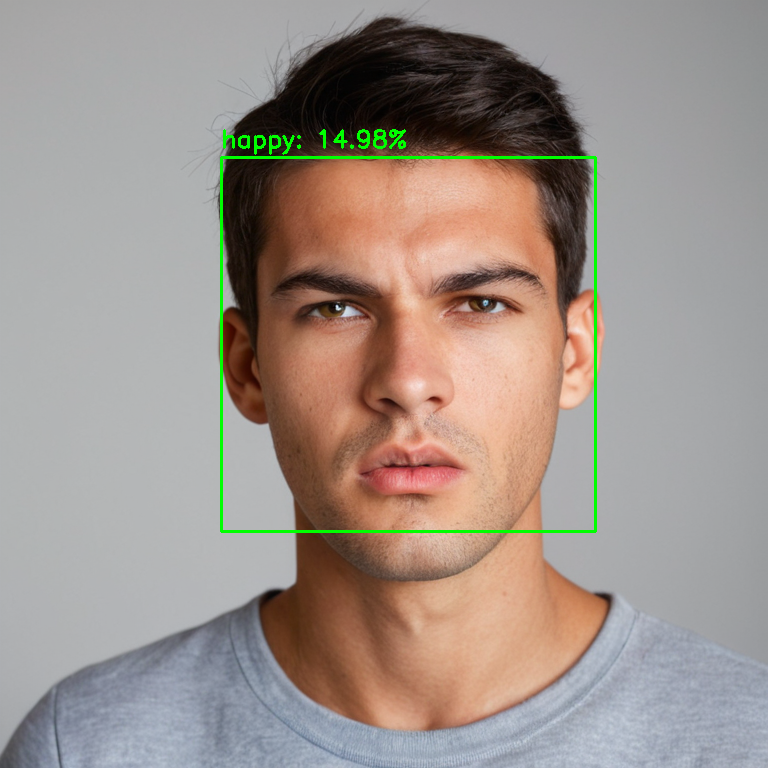

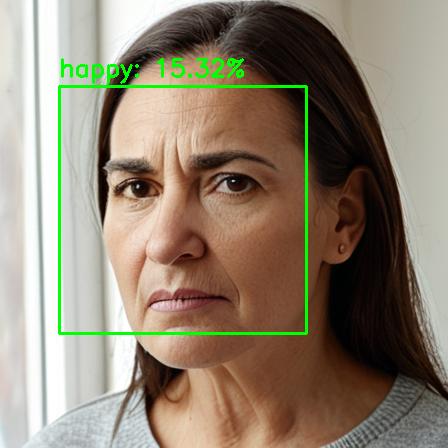

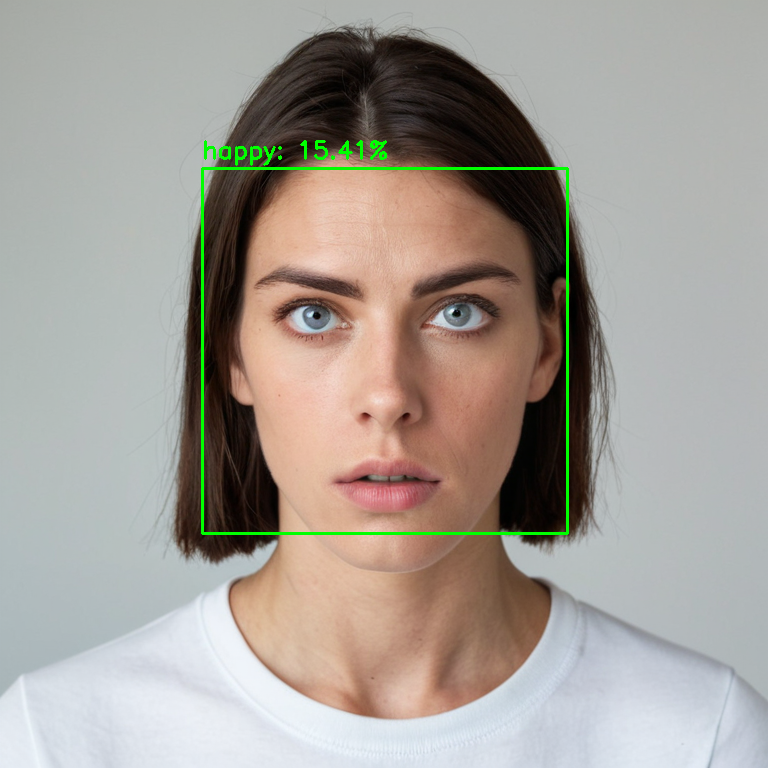

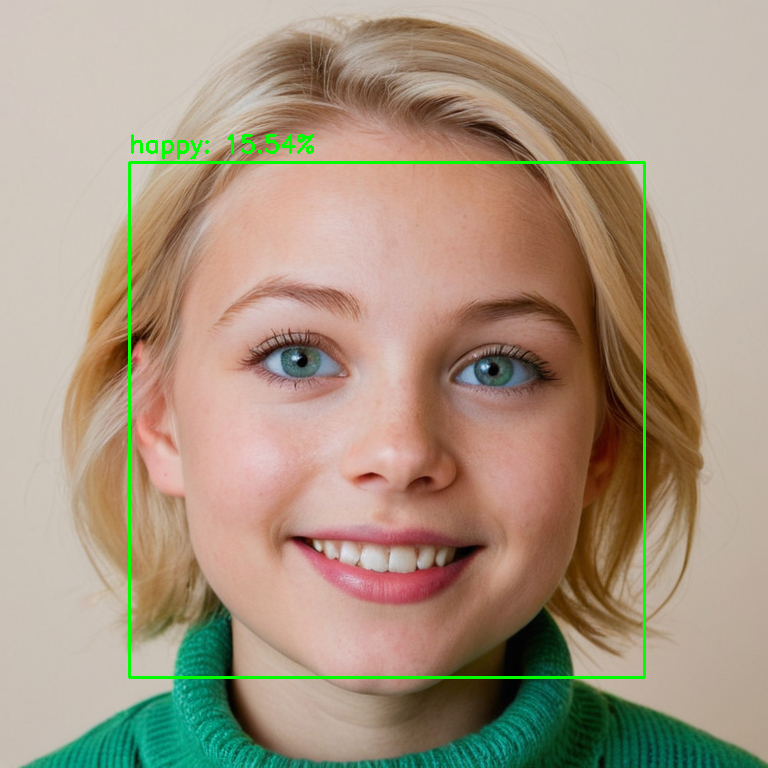

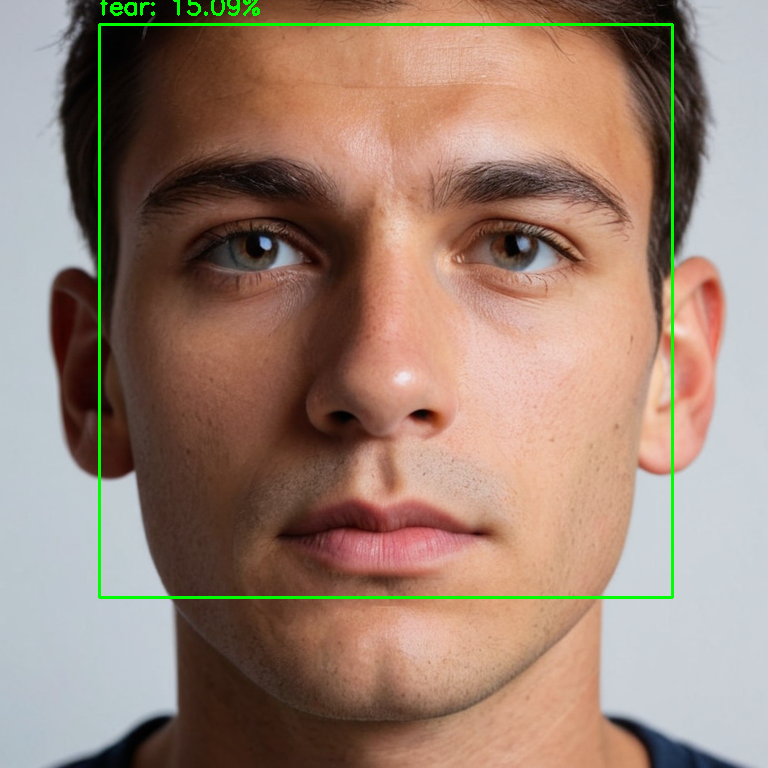

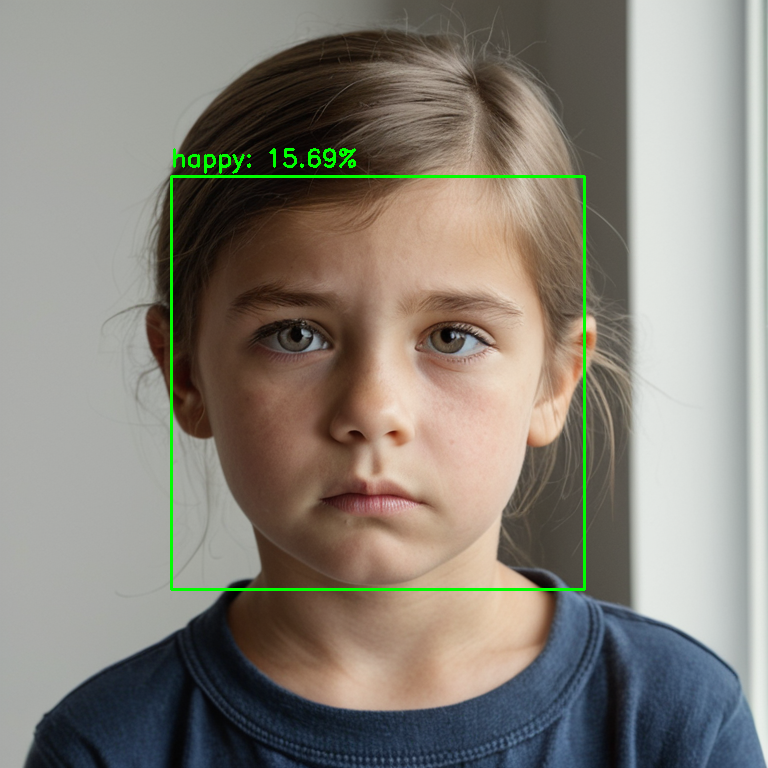

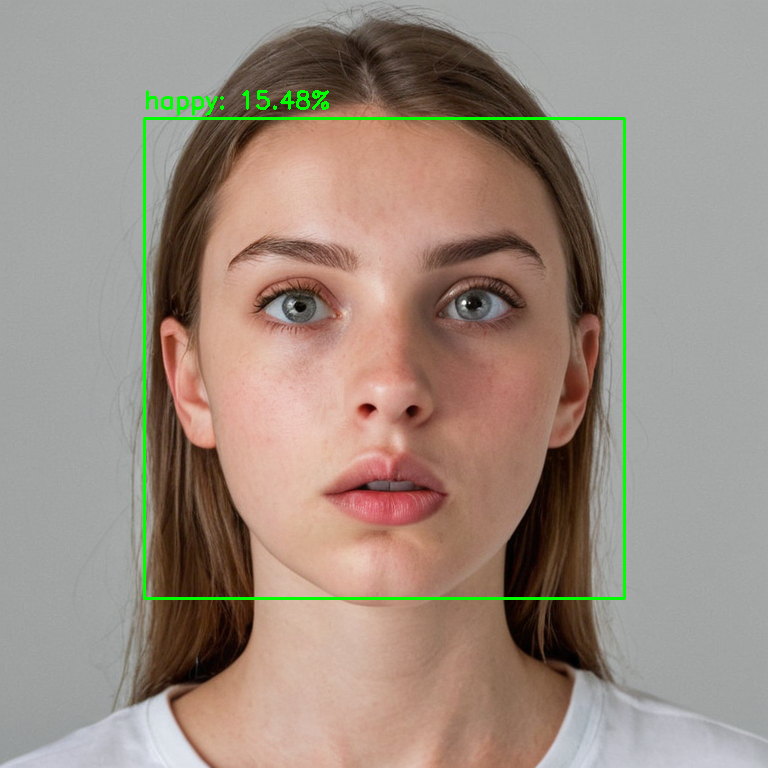

In [37]:
# -----------------------------
# Main function
# -----------------------------
def display_image_with_emotions(image_path):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("No faces detected.")
    else:
        for (x, y, w, h) in faces:
            face_crop = img[y:y+h, x:x+w]

            # Run your FER model
            emotion, proba = inference_untrained(face_crop)

            # Draw rectangle and text
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(
                img,
                f"{emotion}: {round(proba*100,2)}%",
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2
            )

    # Convert BGR → RGB for displaying in Jupyter
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_rgb))


syntetic_path = root_dir/"data"/"syntetic_dataset"
images = [
    syntetic_path/"angry"/"angry_00669_.png",
    syntetic_path/"disgust"/"disgust_00002_.png",
    syntetic_path/"fear"/"fear_00245_.png",
    syntetic_path/"happy"/"happy_00128_.png",
    "/home/natishch/repos/facial-emotion-recognition/data/syntetic_dataset/netural/neutral_00418_.png",
    syntetic_path/"sad"/"sad_jugg_00004_.png",
    syntetic_path/"surprise"/"fear_00033_.png"
]
for img_path in images:
    display_image_with_emotions(img_path)